# Autoencoder - Basic Example

Here, in this notebook, we'll see how to create a basic Autoencoder. For the dataset, we have used Sine function as datasource. 

**NOTE: HERE WE WILL NOT USE THE SINE FUNCTIONS'S DATASET FOR AUTOENCODER TIMESERIES. WE'LL USE IT IN A DIFFERENT LSTM AUTOENCODER.**

In [15]:
import torch.nn as nn
import torch
from torch.nn.modules.container import Sequential
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'
pass

## Loading or Formulating the dataset

In order to create the random dataset let's use the **sine** function. The structure of the dataset would be :

| X   |
| :---: | :--:|
| $[sin(a), sin(a+1), sin(a+2)..., sin(a+n)]$ |
| $[sin(b), sin(b+1), sin(b+2)..., sin(b+n)]$ |
| $... ... ... ... ...$  | ... |
| $[sin(z), sin(z+1), sin(z+2)..., sin(z+n)]$ |

$a ... z$ are the random number between $0 - 100.$<br/>
$n$ is the maximum data points we need. Here we choose it to be 200.<br/>
The rows in the dataset let's say would be $1000$.



In [165]:
main_series = []

for _ in range(0,1000):

    rn = np.random.randint(0,100)

    series_1 = []

    for i in range(rn,rn+200):
        series_1.append(np.sin(i) + 1)

    main_series.append((series_1))

df = pd.DataFrame(main_series)

In [166]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,1.901788,1.123573,0.231745,0.046247,0.737625,1.670229,1.986628,1.395925,0.441211,0.000245,...,0.628568,0.018042,0.310324,1.236691,1.945445,1.784962,0.902788,0.109991,0.135464,0.955787
1,1.313229,1.968364,1.733190,0.823924,0.076542,0.178182,1.035398,1.860069,1.893997,1.105988,...,1.968357,1.313200,0.370089,0.006115,0.555914,1.514004,1.999521,1.566083,0.612191,0.014849
2,1.990607,1.650288,0.712097,0.038603,0.249013,1.149877,1.912945,1.836656,0.991149,0.153780,...,1.202120,0.285102,0.025358,0.661695,1.609068,1.996467,1.467719,0.508952,0.001653,0.412229
3,1.551427,1.999912,1.529083,0.571817,0.008221,0.356462,1.296369,1.963795,1.745113,0.841377,...,1.868951,1.053053,0.188379,0.069905,0.806556,1.721059,1.972623,1.329962,0.383936,0.004316
4,0.737625,1.670229,1.986628,1.395925,0.441211,0.000245,0.478449,1.436165,1.992873,1.636738,...,1.945445,1.784962,0.902788,0.109991,0.135464,0.955787,1.816760,1.926807,1.184752,0.272837


As we see, all the points for sine values are there in individual dataframe's column, so let's grab all the columns and create the array out of it. Leter let's convert that array into a `FloatTensor`.

In [167]:
X_train = df.iloc[:,:].values
X_train_tensor = torch.FloatTensor(X_train).to(device)

Once we have the `FloatTensor`, the next step is to create the `DataLoader` using `TensorDataset`. 

So, let's convert the `FloatTensor` to `TensorDataset` and then `TensorDataset` to `DataLoader`.

In [168]:
train_ds = TensorDataset(X_train_tensor, X_train_tensor)
train_loader = DataLoader(train_ds, 128, shuffle=True)

## Modelling

### **Encoder**

The first part of the an **AutoEncoder** model is the **Encoder**. The Encoder would take a $200$ features in this case (as our sine dataset has $200$ features created) and layer by layer, it will reduce the size of the features to $25$ points in the end.

In [169]:

class EncoderNN(nn.Module):

    def __init__(self):
        super(EncoderNN, self).__init__()

        self.encoder = Sequential(                
                nn.Linear(200, 100),  
                nn.ReLU(),
                nn.Linear(100, 50),  
                nn.ReLU(), 
                nn.Linear(50, 25),  
                nn.ReLU()
        )

    def forward(self, x):
        return self.encoder(x)

### **Decoder**

The second part of the an **AutoEncoder** model is the **Decoder**. The Decoder would take it from where Encoder finishes. The Decoder would take the $25$ features here in this case and layer by layer it will increase the size of the features from $25$ to $200$ points in the end.

So the Decoder again reconstructs the data to the same number of data points form where the Encoder started. We will then use this reconstructed data, compare it with the original data and calculate the $MSE$. The whole idea is to try reduce this error.

In [170]:
class DecoderNN(nn.Module):

    def __init__(self):
        super(DecoderNN, self).__init__()

        self.decoder = Sequential(   
                nn.Linear(25, 50),  
                nn.ReLU(), 
                nn.Linear(50, 100),  
                nn.ReLU(), 
                nn.Linear(100, 200),  
                nn.ReLU()
        )

    def forward(self, x):
        return self.decoder(x)

In [171]:
class AutoencoderNN(nn.Module):

  def __init__(self):
    super(AutoencoderNN,self).__init__()
    
    self.encoderNN = EncoderNN().to(device)
    self.decoderNN = DecoderNN().to(device)


  def forward(self,x):
    x = self.encoderNN(x)
    x = self.decoderNN(x)
    return x

In [172]:
model = AutoencoderNN().to(device)
print(model)

AutoencoderNN(
  (encoderNN): EncoderNN(
    (encoder): Sequential(
      (0): Linear(in_features=200, out_features=100, bias=True)
      (1): ReLU()
      (2): Linear(in_features=100, out_features=50, bias=True)
      (3): ReLU()
      (4): Linear(in_features=50, out_features=25, bias=True)
      (5): ReLU()
    )
  )
  (decoderNN): DecoderNN(
    (decoder): Sequential(
      (0): Linear(in_features=25, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=100, bias=True)
      (3): ReLU()
      (4): Linear(in_features=100, out_features=200, bias=True)
      (5): ReLU()
    )
  )
)


In [173]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

In [174]:
epochs = 100

running_loss_history = []
epoch_list = []

for epoch in range(epochs):

    # See we're not using any labels here.

    for inputs, _ in train_loader:

        inputs = inputs.to(device)

        optimizer.zero_grad()

        output = model(inputs)

        # Compairing the output with the input and not the labels
        loss = criterion(output, inputs)
        
        loss.backward()
        optimizer.step()

        running_loss = loss.item()

    
    if (epoch+1) % 10 == 0:

        running_loss_history.append(running_loss)
        
        print('epoch :', (epoch+1))
        print('training loss: {:.4f}'.format(running_loss))
        epoch_list.append(epoch + 1)

        print('_'*20)

epoch : 10
training loss: 0.1711
____________________
epoch : 20
training loss: 0.1490
____________________
epoch : 30
training loss: 0.1492
____________________
epoch : 40
training loss: 0.1496
____________________
epoch : 50
training loss: 0.1482
____________________
epoch : 60
training loss: 0.1502
____________________
epoch : 70
training loss: 0.1490
____________________
epoch : 80
training loss: 0.1517
____________________
epoch : 90
training loss: 0.1505
____________________
epoch : 100
training loss: 0.1483
____________________


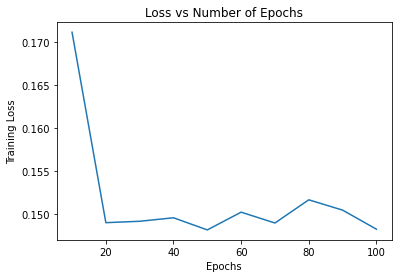

In [175]:
plt.plot(epoch_list,running_loss_history)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Loss vs Number of Epochs")
plt.show()

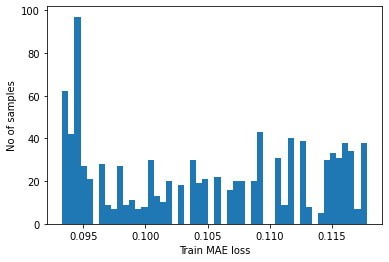

Reconstruction error threshold:  0.1177756958492823


In [176]:
x_train_pred = model(X_train_tensor).to('cpu').detach().numpy()

train_mae_loss = np.mean(np.abs(x_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

Here, since we know that every row represents a sine series, so we can try plotting it and see the results. Both the prediction and the actual data should represent a sine series. This might not be true for other datasets.

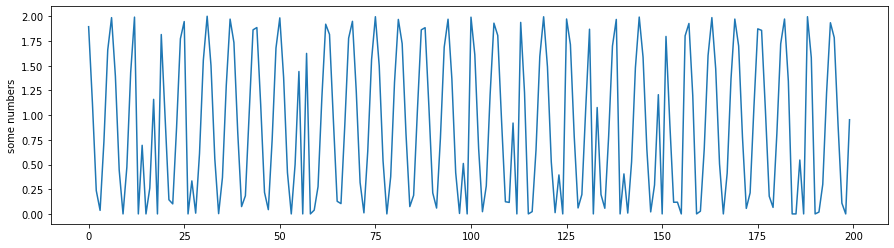

In [180]:
plt.figure(figsize=(15,4))
plt.plot(x_train_pred[0])
#plt.plot(X_train[0])
plt.ylabel('some numbers')
plt.show()

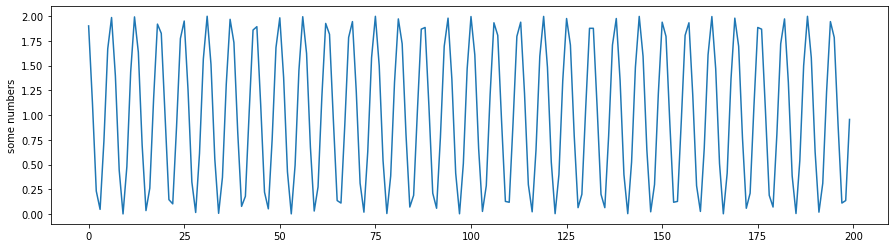

In [181]:
plt.figure(figsize=(15,4))
plt.plot(X_train[0])
plt.ylabel('some numbers')
plt.show()